# GSS Data Analysis

In this notebook, we'll be analyzing the GSS (General Social Survey) dataset, which contains information about individuals collected from 1972 to 2022. Unfortunately, due to data constraints, I couldn't include the dataset in this repository. The dataset is available for download at: https://gss.norc.org/us/en/gss/get-the-data.html. You'll need to select the STATA version and download the cumulative dataset (the first option).

## Data Processing

First, let's import the required libraries and our data.

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_stata('gss_data/gss7222_r4.dta', convert_categoricals=False)

Due to the way the data was encoded, cell values are strings. Let's address that and make sure the data is formatted correctly.

In [21]:
# Get the list of column names
column_names = df.columns.tolist()

# Clean and convert object type columns
for name in column_names:
    if df[name].dtype == 'object':
        # Strip whitespace from the beginning and end of each string
        df[name] = df[name].str.strip()
        
        # Replace patterns like '.a', '.b', etc. with 'NaN'
        df[name] = df[name].str.replace(r'\.[a-z]', 'NaN', regex=True)
        
        # Replace 'NaN' strings with actual NaN values and convert to Int64
        df[name] = df[name].replace('NaN', np.nan).astype('Int64')

Now that we've fixed our DataFrame, let's take a quick look at it.

Note: you'll notice a lot of NAs, but we are keeping them in the interest of conserving the integrity of the data until we fit models to the data.

In [22]:
# Print information about the data
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
# print(df.info()) # Uncomment to see more detailed information

# Print the first 6 rows
df.head(6)

Rows: 72390, Columns: 6696


,year,id,wrkstat,hrs1,hrs2,evwork,occ,prestige,wrkslf,wrkgovt,...,agehef13,agehef14,hompoph,hhtype1_exp,batch,subsamprate,wtssps_nea,wtssnrps_nea,wtssps_next,wtssnrps_next
0,1972,1,1.0,NaN,NaN,NaN,205.0,50.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1972,2,5.0,NaN,NaN,1.0,441.0,45.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1972,3,2.0,NaN,NaN,NaN,270.0,44.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1972,4,1.0,NaN,NaN,NaN,1.0,57.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1972,5,7.0,NaN,NaN,1.0,385.0,40.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1972,6,1.0,NaN,NaN,NaN,281.0,49.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Exploratory Data Analysis

Let's explore some of the features in our data and visualize them. Each variable is described in detail under the corresponding subheading.

### GSS Survey Years

To begin, let's take a look at how many respondents we have per year to get an idea of how much data we're working with.

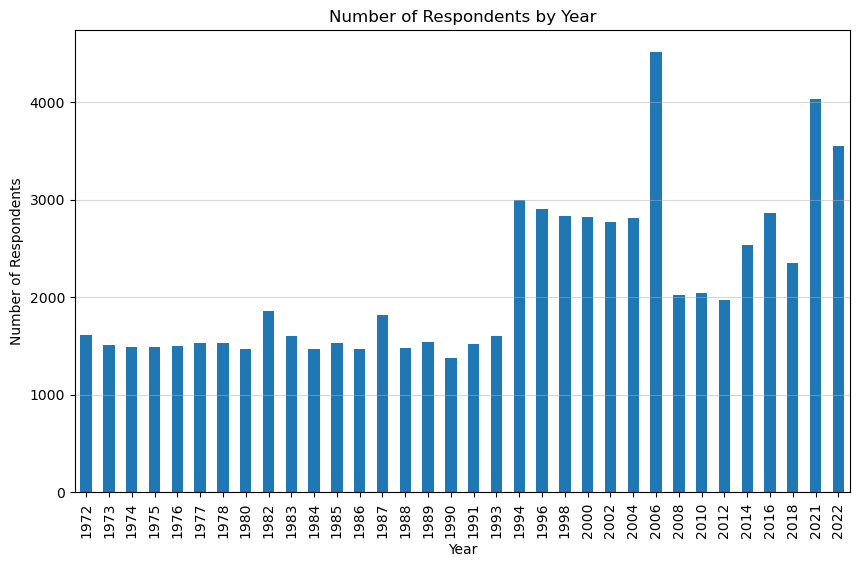

In [23]:
# Bar chart of the number of respondents by year
plt.figure(figsize=(10, 6))
df['year'].value_counts().sort_index().plot(kind='bar')
plt.title('Number of Respondents by Year')
plt.xlabel('Year')
plt.ylabel('Number of Respondents')
plt.grid(axis='y', alpha=0.5)
plt.show()

We can note a few things from this plot:
- The number of respondents increased dramatically during 1994 and 2006. Similarly, the respondent count decreased steeply in 2008 (probably due to the Great Recession).
- All odd years after 1998 are missing. This is due to changes in the way the survey data was collected.
- The data has a few irregular skips in years: from 1991 to 1993 (for uknown reasons), and 2018 to 2021 (due to the COVID pandemic).

These are things to keep in mind if you are using the full dataset for analysis or prediction. In this case, we'll focus on the latest data to examine the various characteristics of the respondents in the sample.

In [24]:
df_latest = df[df['year'] == 2022]

### Age Distribution

First, let's look at the age distribution of the respondents to get a clearer picture.

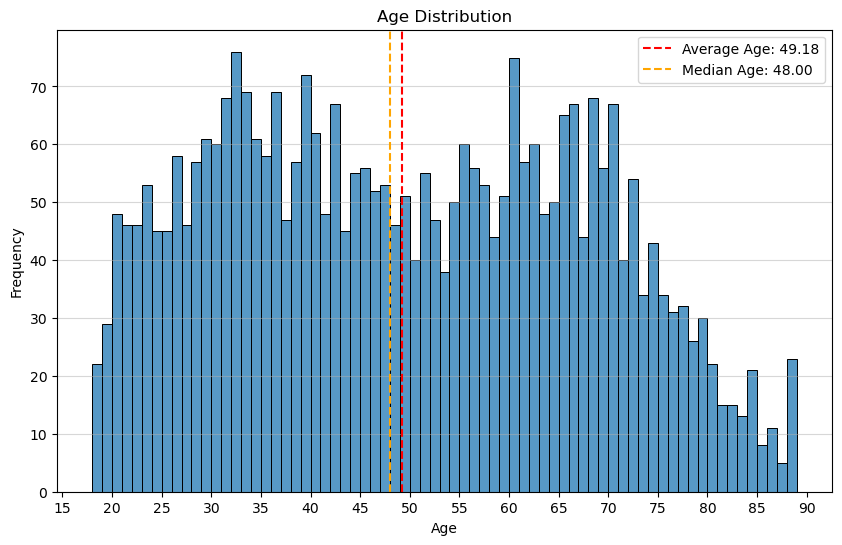

In [25]:
# Calculate average and median age
average_age = df_latest['age'].mean()
median_age = df_latest['age'].median()

plt.figure(figsize=(10, 6))
sns.histplot(df_latest['age'], bins=df_latest['age'].nunique()-1)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.5)
plt.xticks(range(15, 95, 5))
plt.axvline(average_age, color='r', linestyle='--', label=f'Average Age: {average_age:.2f}')
plt.axvline(median_age, color='orange', linestyle='--', label=f'Median Age: {median_age:.2f}')
plt.legend()
plt.show()

We can see that the mean age for respondents is 49 years. However, since we can discern a bit of a bimodal distribution, simply calculating the usual measures of center won't work very well. Let's split the data in half, calculate the median, and then plot the age distribution again to see if we can get a better idea.

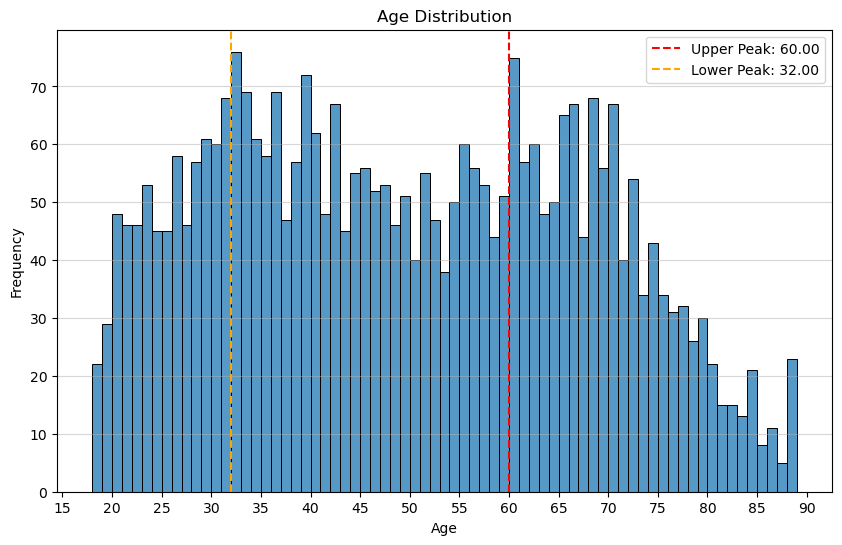

In [26]:
median_age = df_latest['age'].median()
large_peak = df_latest[df_latest['age'] >= median_age]['age'].mode().values[0]
small_peak = df_latest[df_latest['age'] < median_age]['age'].mode().values[0]

plt.figure(figsize=(10, 6))
sns.histplot(df_latest['age'], bins=df_latest['age'].nunique()-1)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.5)
plt.xticks(range(15, 95, 5))
plt.axvline(large_peak, color='r', linestyle='--', label=f'Upper Peak: {large_peak:.2f}')
plt.axvline(small_peak, color='orange', linestyle='--', label=f'Lower Peak: {small_peak:.2f}')
plt.legend()
plt.show()

We can see that most respondents are actually around 32 or 60 years old. We begin to have a clearer pictue, but let's not stop there!

### Household Size and Composition

Now that we know the age of the respondents, let's explore their living conditions. First, we'll be looking at household size.

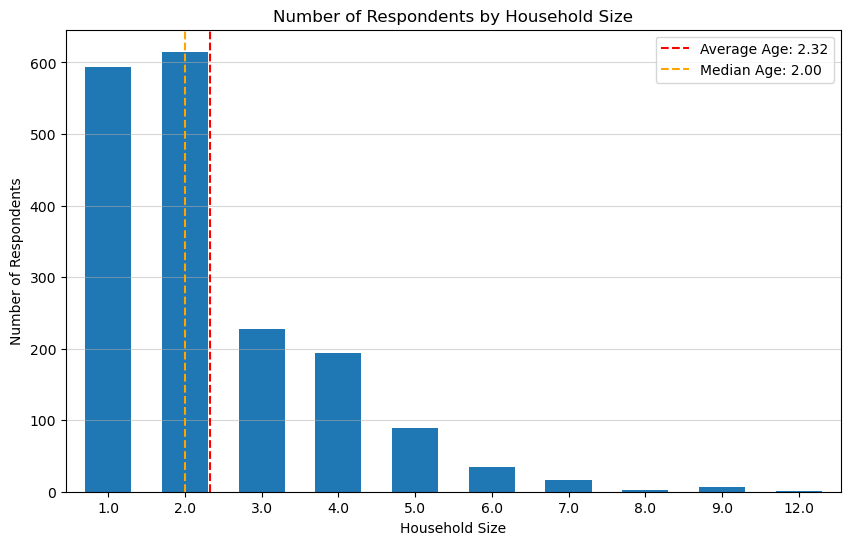

In [27]:
# Calculate average household size
average_hompop = df_latest['hompop'].mean()
median_hompop = df_latest['hompop'].median()

# Plot the bar chart
ax = df_latest['hompop'].value_counts().sort_index().plot(kind='bar', width=0.6, figsize=(10, 6))
plt.title('Number of Respondents by Household Size')
plt.xlabel('Household Size')
plt.ylabel('Number of Respondents')
plt.grid(axis='y', alpha=0.5)
plt.xticks(rotation=0)

# Plot median and average lines
plt.axvline(average_hompop-1, color='r', linestyle='--', label=f'Average Age: {average_hompop:.2f}')
plt.axvline(median_hompop-1, color='orange', linestyle='--', label=f'Median Age: {median_hompop:.2f}')

# Fix the legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[:2], labels[:2])
plt.show()

In this case, the median household size is 2, however, we can see that most households are either size 1 or 2. Let's dive deeper and break down the data to understand who lives in these households.

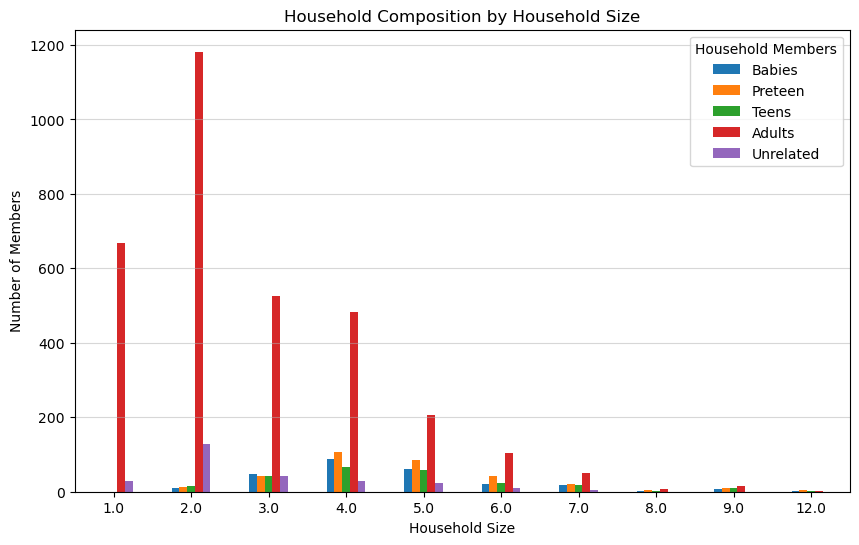

In [28]:
household_vars = ['babies', 'preteen', 'teens', 'adults', 'unrelat']
formatted_names = ['Babies', 'Preteen', 'Teens', 'Adults', 'Unrelated']

# Group the data by household size and sum the household variables
household_composition = df_latest.groupby('hompop')[household_vars].sum()

# Plot the grouped bar chart
household_composition.plot(kind='bar', figsize=(10, 6))
plt.title('Household Composition by Household Size')
plt.xlabel('Household Size')
plt.ylabel('Number of Members')
plt.legend(labels=formatted_names, title='Household Members')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.5)
plt.show()

As it turns out, most households are composed of adults only, by a lot. Pretty surprising, right? A pattern begins to emerge: most households are size 2, and most households are adult only. We can guess that most of these people are adults that live with their spouse/partner. 

### Marital Status

Let's investigate the marital status of the population to confirm our earlier suspicions (that most people are living as couples).

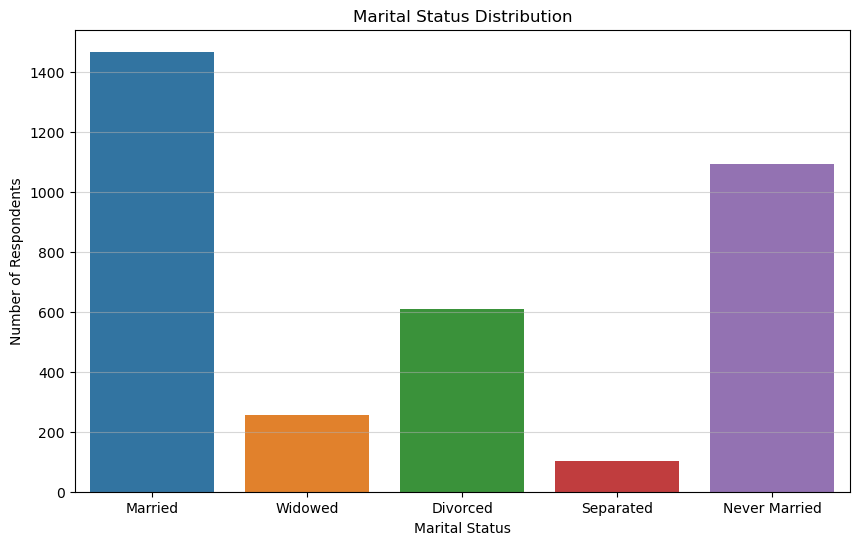

In [36]:
# Create a copy of the data with only the relevant columns
marital_data = df_latest[['hompop', 'marital']].copy()

# Define marital status mapping
marital_mapping = {
    1.0: 'Married',
    2.0: 'Widowed',
    3.0: 'Divorced',
    4.0: 'Separated',
    5.0: 'Never Married'
}

# Map the marital status codes to labels
marital_data['marital_status'] = marital_data['marital'].map(marital_mapping)

# Define a consistent color palette
palette = {
    'Married': '#1f77b4',
    'Widowed': '#ff7f0e',
    'Divorced': '#2ca02c',
    'Separated': '#d62728',
    'Never Married': '#9467bd'
}

# Plot the relationship between marital status and household size
plt.figure(figsize=(10, 6))
sns.countplot(data=marital_data, x='marital_status', hue='marital_status', order=['Married', 'Widowed', 'Divorced', 'Separated', 'Never Married'], legend=False, palette=palette)
plt.title('Marital Status Distribution')
plt.xlabel('Marital Status')
plt.ylabel('Number of Respondents')
plt.grid(axis='y', alpha=0.5)
plt.show()

As it turns out, we actually have quite a significant number of people that have never been married or are divorcced, despite the majority are married. Maybe most respondents are cohabitating and aren't married. Let's put this theory to the test!

### Household Sizes 1-2

Let's try subsetting the data and focusing on households that are size 1 and 2 with adults only, since these represent the majority. Perhaps we'll be able to separate the signal from the noise this way. First, let's look at age again.

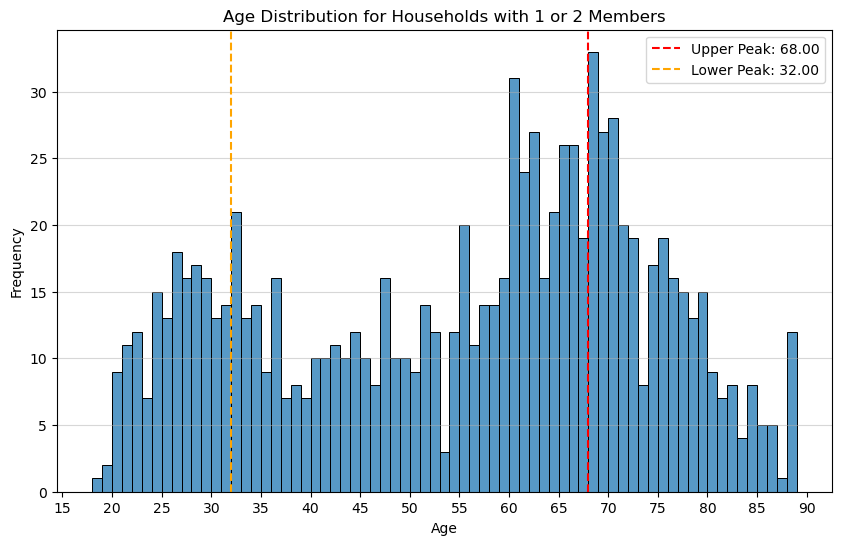

In [44]:
# Split the data into rows that have hompop==1 and hompop==2
hompop_1 = df_latest[df_latest['hompop'] == 1]
hompop_2 = df_latest[df_latest['hompop'] == 2]

# Further subset these separate datasets by ones that have adults==1 and adults==2 correspondingly
hompop_1_adults_1 = hompop_1[hompop_1['adults'] == 1]
hompop_2_adults_2 = hompop_2[hompop_2['adults'] == 2]

# Concatenate these datasets to make it one dataset again
subset_data = pd.concat([hompop_1_adults_1, hompop_2_adults_2])

# Calculate peaks
median_age = subset_data['age'].median()
large_peak = subset_data[subset_data['age'] >= median_age]['age'].mode().values[0]
small_peak = subset_data[subset_data['age'] < median_age]['age'].mode().values[0]

plt.figure(figsize=(10, 6))
sns.histplot(subset_data['age'], bins=subset_data['age'].nunique()-1)
plt.title('Age Distribution for Households with 1 or 2 Members')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.5)
plt.xticks(range(15, 95, 5))
plt.axvline(large_peak, color='r', linestyle='--', label=f'Upper Peak: {large_peak:.2f}')
plt.axvline(small_peak, color='orange', linestyle='--', label=f'Lower Peak: {small_peak:.2f}')
plt.legend()
plt.show()

Surprisingly, the age distribution shape largely the same, except the peaks are more pronounced. However, we do see the upper peak shift from 60 to 68. Let's look at the composition of the households to see if we get the same result as earlier.

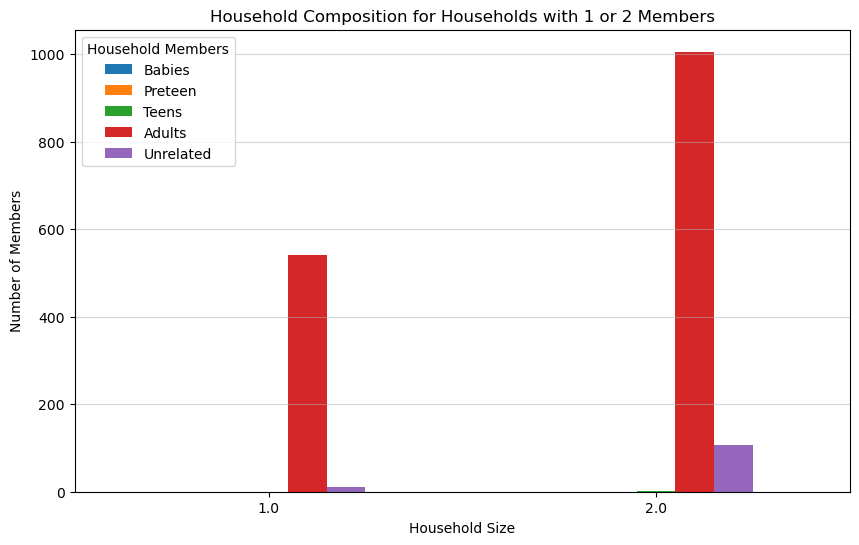

In [38]:
household_vars = ['babies', 'preteen', 'teens', 'adults', 'unrelat']
formatted_names = ['Babies', 'Preteen', 'Teens', 'Adults', 'Unrelated']

# Group the data by household size and sum the household variables
household_composition = subset_data.groupby('hompop')[household_vars].sum()

# Plot the grouped bar chart
household_composition.plot(kind='bar', figsize=(10, 6))
plt.title('Household Composition for Households with 1 or 2 Members')
plt.xlabel('Household Size')
plt.ylabel('Number of Members')
plt.legend(labels=formatted_names, title='Household Members')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.5)
plt.show()

We're getting somewhere! We can see that some households have two unrelated adults living together, which may indicate they're living with friends/roommates. Let's look at marital status to finish our analysis.

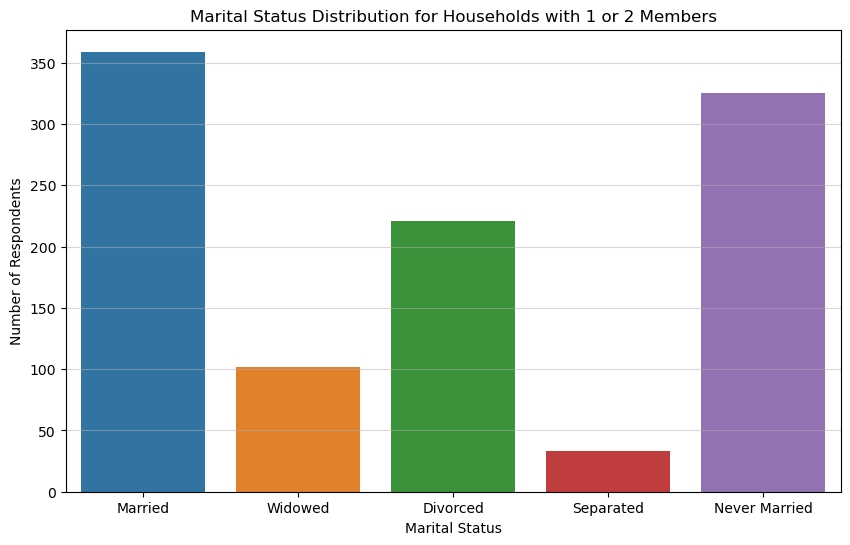

In [43]:
# Create a copy of the data with only the relevant columns
marital_data = subset_data[['hompop', 'marital']].copy()

# Define marital status mapping
marital_mapping = {
    1.0: 'Married',
    2.0: 'Widowed',
    3.0: 'Divorced',
    4.0: 'Separated',
    5.0: 'Never Married'
}

# Map the marital status codes to labels
marital_data['marital_status'] = marital_data['marital'].map(marital_mapping)

# Define a consistent color palette
palette = {
    'Married': '#1f77b4',
    'Widowed': '#ff7f0e',
    'Divorced': '#2ca02c',
    'Separated': '#d62728',
    'Never Married': '#9467bd'
}

# Plot the relationship between marital status and household size
plt.figure(figsize=(10, 6))
sns.countplot(data=marital_data, x='marital_status', hue='marital_status', order=['Married', 'Widowed', 'Divorced', 'Separated', 'Never Married'], legend=False, palette=palette)
plt.title('Marital Status Distribution for Households with 1 or 2 Members')
plt.xlabel('Marital Status')
plt.ylabel('Number of Respondents')
plt.grid(axis='y', alpha=0.5)
plt.show()

What a plot twist! It turns out that we have a significantly large number of people that have never been married or are divorced. It would seem like most people are indeed cohabitating.

This is just the beginning of a large rabbit hole! You can try doing your own analyses and coming up with your own conclusions using the gss dataset.

## Data Modeling

Now, let's focus on fitting a few models that attempt to predict `income` using other variables. For this task, we'll only be using data from 1998-2022.

### Data Preprocessing

Let's subset our data and get rid of variables that have more than 25% NAs. We'll also fill NAs with the median of the column to avoid adding bias our data.

In [40]:
### Data Preprocessing ###

# Filter the data for 2021-2022
df_model = df[df['year'].isin(range(1998, 2023))].copy()

# Drop rows with missing values in the 'income' column
df_model.dropna(subset=['income'], inplace=True)

# Drop columns with more than 30% missing values
df_model.dropna(thresh=0.7*len(df_model), axis=1, inplace=True)

# Fill missing values with the median
df_model.fillna(df.median(), inplace=True)

# Assign weights based on the year
sample_weights = np.where(df_model['year'] <= 2018, df_model['wtssall'], df_model['wtssps'])

# Define the features and target variable
X = df_model.drop(columns=['income'])
y = df_model['income']

### Fitting Models

Now let's try to fit a Decision Tree and a Random Forest Classifier. These models seem ideal given the number of categorical variables present in the dataset. They also work similarly, so we can easily compare their results.

In [41]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

# Initialize the classifiers
dt_classifier = DecisionTreeClassifier(random_state=42)
rf_classifier = RandomForestClassifier(random_state=42)

# Define the scoring metrics with zero_division parameter
scoring = {
	'accuracy': 'accuracy',
	'precision_macro': make_scorer(precision_score, average='macro', zero_division=1),
	'recall_macro': make_scorer(recall_score, average='macro', zero_division=1),
	'f1_macro': make_scorer(f1_score, average='macro', zero_division=1)
}

# Cross-validate the models
cv = KFold(n_splits=5, shuffle=True, random_state=42)
dt_scores = cross_validate(dt_classifier, X, y, cv=cv, scoring=scoring, params={'sample_weight': sample_weights}, return_train_score=False)
rf_scores = cross_validate(rf_classifier, X, y, cv=cv, scoring=scoring, params={'sample_weight': sample_weights}, return_train_score=False)

# Print the results
print('Decision Tree Classifier:')
for metric, values in dt_scores.items():
    print(f'{metric}: {values.mean():.4f}')

print('\nRandom Forest Classifier:')
for metric, values in rf_scores.items():
    print(f'{metric}: {values.mean():.4f}')

Decision Tree Classifier:
fit_time: 0.8251
score_time: 0.0131
test_accuracy: 0.9918
test_precision_macro: 0.9633
test_recall_macro: 0.9666
test_f1_macro: 0.9646

Random Forest Classifier:
fit_time: 7.6779
score_time: 0.1990
test_accuracy: 0.9463
test_precision_macro: 0.7259
test_recall_macro: 0.5969
test_f1_macro: 0.6214


We can see that household composition, age, and marital status are reasonably good predictors of income, since we get 0.78 and 0.84 for accuracy. You can also see that we get a higher accuracy score using a Random Forest algorithm, but at the cost of precision and recall. In this case, a decision tree might be the best choice, as it less computationally expensive, it is more interpretable, and it seems to have a reasonable score in all metrics.

### Inspecting Models

Let's see what variables both models prioritized to understand why they might have differences in their score. Due to space constraints, we'll only check the first 5.

In [42]:
# Fit the models
rf_classifier.fit(X, y)
dt_classifier.fit(X, y)

# Get the top 5 features
dt_feature = pd.Series(dt_classifier.feature_importances_, index=X.columns).sort_values(ascending=False)[:5]
rf_feature = pd.Series(rf_classifier.feature_importances_, index=X.columns).sort_values(ascending=False)[:5]

# Print the top 5 features
print('Decision Tree Feature Importances:')
print(dt_feature)

print('\nRandom Forest Feature Importances:')
print(rf_feature)

Decision Tree Feature Importances:
realinc    0.645671
vstrat     0.190097
coninc     0.114236
year       0.036166
sample     0.001320
dtype: float64

Random Forest Feature Importances:
coninc     0.241243
realinc    0.234910
vstrat     0.017006
sei10      0.013828
finrela    0.013803
dtype: float64


As we can see, most variables are different, except realinc and vstrat, which appear in both lists but in different positions. Expanding this list might give us insight when trying to select features and build a more robust model.

## Conclusion

That's it for today. this is just the beginning! You can continue analyzing this dataset and come up with your own conclusions. Let me know what you come up with and share your repositories with me! This is a very rich and fun dataset to play around with.

**Happy feature hunting!**